In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
from math import pi
import m8r
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from scipy.interpolate import interp1d
from tabulate import tabulate

In [91]:
specfem_datapath='/home/unitel/Documentos/specfem3d_examples/random_top/OUTPUT_FILES/'
ewtop3d_datapath='../groll_modeling/homo_3d_topo/'

In [92]:
topo = m8r.Input(ewtop3d_datapath+'top.rsf')
o1=topo.float('o1')
d1=topo.float('d1')
n1=topo.int('n1')
o2=topo.float('o2')
d2=topo.float('d2')
n2=topo.int('n2')
top = topo.read(shape=(n2,n1)).T

top.shape
top=1000*top+95
rec_x = np.linspace(0,3000,61)
rec_y = 1000*np.ones((61,1))

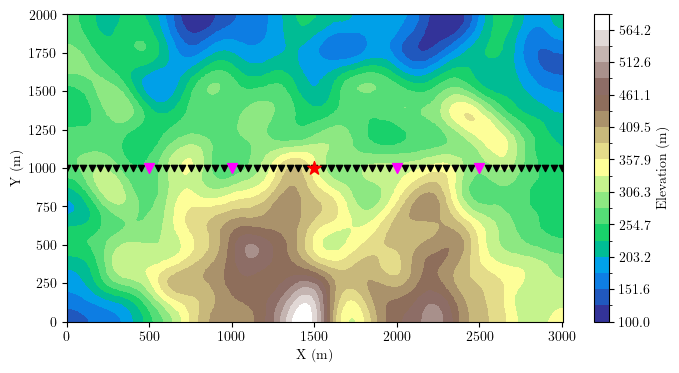

In [93]:
plt.rcParams['figure.figsize'] = [8, 4]
import matplotlib as mpl

cmap = plt.cm.terrain  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(top.min(), top.max(), 20)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure()
plt.imshow(top.T, cmap=cmap, norm=norm, origin='lower', aspect='auto',
           extent=[o1, o1+d1*n1*1000, o2, o2+d2*n2*1000,])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
cbar=plt.colorbar()
cbar.set_label('Elevation (m)')
plt.scatter(rec_x,rec_y,s=20,marker='v',color='black')
plt.scatter([500,1000,2000,2500],4*[1000],s=50,marker='v',color='fuchsia')
plt.scatter(1500,1000,s=100,marker='*',color='red')
#fig.savefig('elevation_map.pdf',bbox_inches='tight')

In [94]:
traceXavm = m8r.Input(ewtop3d_datapath+'traceX2.rsf')
traceYavm = m8r.Input(ewtop3d_datapath+'traceY2.rsf')
traceZavm = m8r.Input(ewtop3d_datapath+'traceZ2.rsf')
o1=traceZavm.float('o1')
d1=traceZavm.float('d1')
n1=traceZavm.int('n1')
o2=traceZavm.float('o2')
d2=traceZavm.float('d2')
n2=traceZavm.int('n2')
dataXavm = traceXavm.read(shape=(n2,n1)).T
dataYavm = traceYavm.read(shape=(n2,n1)).T
dataZavm = traceZavm.read(shape=(n2,n1)).T
time = np.arange(o1,n1*d1,d1)
offset = np.arange(o2,n2*d2,d2)
print(np.shape(dataZavm))

(452, 301)


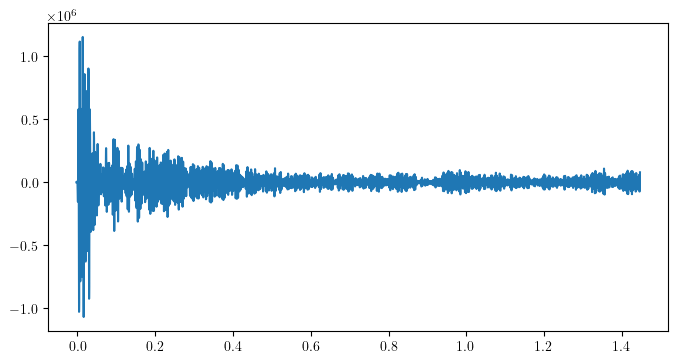

In [95]:
traceZ = pd.read_csv(specfem_datapath+"CE.RX1500Y1000.FXZ.semv", header = None, skipinitialspace=True, delimiter=" ") 
plt.plot(traceZ[0],traceZ[1])

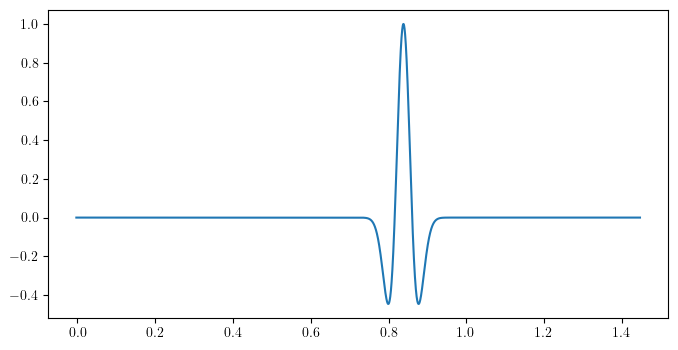

In [96]:
t = traceZ[0].to_numpy()
fq = 10
t0 = t[-1]/2+1.15/fq
source = (1-2*pi**2*fq**2*(t-t0)**2)*np.exp(-pi**2*fq**2*(t-t0)**2)
plt.plot(t,source)

In [97]:
rec_x = range(10,3000,10)
y=1100

k=0
dataX=np.zeros(shape=(np.size(time),np.size(rec_x)))
dataY=np.zeros(shape=(np.size(time),np.size(rec_x)))
dataZ=np.zeros(shape=(np.size(time),np.size(rec_x)))
for x in rec_x:
    filenameZ = specfem_datapath+'CE.RX'+str(x)+'Y'+str(y)+'.FXZ.semv'
    filenameX = specfem_datapath+'CE.RX'+str(x)+'Y'+str(y)+'.FXX.semv'
    filenameY = specfem_datapath+'CE.RX'+str(x)+'Y'+str(y)+'.FXY.semv'
    traceX = pd.read_csv(filenameX, header = None, skipinitialspace=True, delimiter=" ")
    traceY = pd.read_csv(filenameY, header = None, skipinitialspace=True, delimiter=" ")
    traceZ = pd.read_csv(filenameZ, header = None, skipinitialspace=True, delimiter=" ")
    hX = traceX[1].to_numpy()
    hY = traceY[1].to_numpy()
    hZ = traceZ[1].to_numpy()
    traceX = np.convolve(hX,source,mode='same')
    traceY = np.convolve(hY,source,mode='same')
    traceZ = np.convolve(hZ,source,mode='same')
    fX = interp1d(t, traceX,bounds_error=False,fill_value=(0,0))
    fY = interp1d(t, traceY,bounds_error=False,fill_value=(0,0))
    fZ = interp1d(t, traceZ,bounds_error=False,fill_value=(0,0))
    dataX[:,k] = fX(time)
    dataY[:,k] = fY(time)
    dataZ[:,k] = fZ(time)
    k+=1
print(np.shape(dataZ))

(452, 299)


In [98]:
scalerX = MaxAbsScaler()
scalerY = MaxAbsScaler()
scalerZ = MaxAbsScaler()
scalerX.fit(dataX)
scalerY.fit(dataY)
scalerZ.fit(dataZ)
dataX_norm=scalerX.fit_transform(dataX)
dataY_norm=scalerY.fit_transform(dataY)
dataZ_norm=scalerZ.fit_transform(dataZ)
dataXavm_norm=scalerX.fit_transform(dataXavm[:,1:-1])
dataYavm_norm=scalerY.fit_transform(dataYavm[:,1:-1])
dataZavm_norm=scalerZ.fit_transform(dataZavm[:,1:-1])

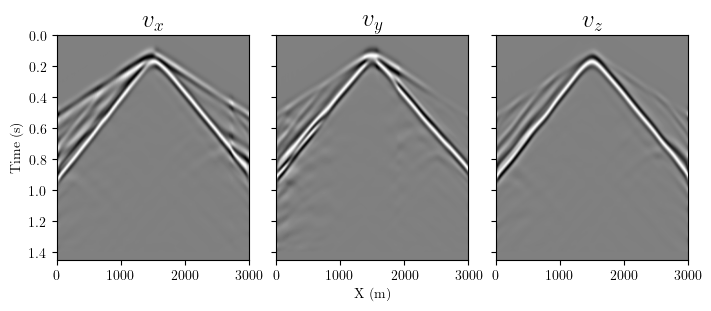

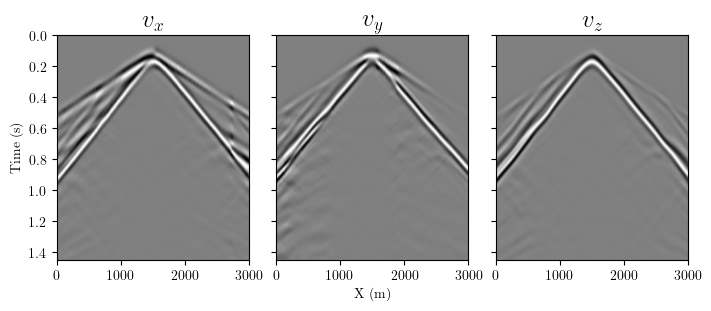

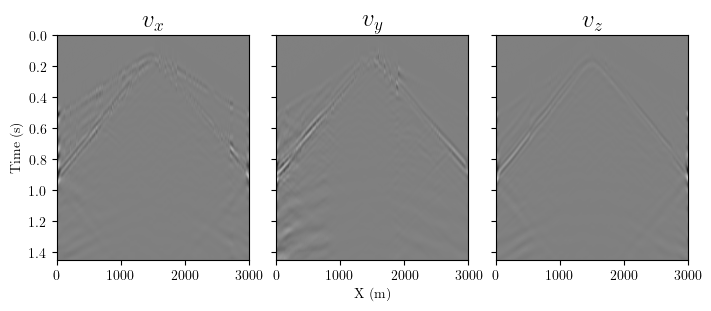

In [99]:
plt.rcParams['figure.figsize'] = [7, 3]
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
pc=1.0

xmin=0
xmax=3000
fig1, (ax1, ax2,ax3) = plt.subplots(1, 3, layout='constrained', sharey=True)
ax1.set_title('$v_x$', fontsize=18)
ax1.imshow(dataX_norm, cmap='gray', vmin=-pc, vmax=pc, origin='upper', aspect='auto',
           extent=[xmin, xmax, t[-1], t[0]])
ax1.set_ylabel('Time (s)')
ax2.set_title('$v_y$', fontsize=18)
ax2.imshow(dataY_norm, cmap='gray', vmin=-pc, vmax=pc, origin='upper', aspect='auto',
           extent=[xmin, xmax, t[-1], t[0]])
ax2.set_xlabel('X (m)')
ax3.set_title('$v_z$', fontsize=18)
ax3.imshow(dataZ_norm, cmap='gray', vmin=-pc, vmax=pc, origin='upper', aspect='auto',
           extent=[xmin, xmax, t[-1], t[0]])
#fig1.suptitle('SPECFEM3D', fontsize=12)

fig2, (ax1, ax2,ax3) = plt.subplots(1, 3, layout='constrained', sharey=True)
ax1.set_title('$v_x$', fontsize=18)
ax1.imshow(dataXavm_norm, cmap='gray', vmin=-pc, vmax=pc, origin='upper', aspect='auto',
           extent=[xmin, xmax, t[-1], t[0]])
ax1.set_ylabel('Time (s)')
ax2.set_title('$v_y$', fontsize=18)
ax2.imshow(dataYavm_norm, cmap='gray', vmin=-pc, vmax=pc, origin='upper', aspect='auto',
           extent=[xmin, xmax, t[-1], t[0]])
ax2.set_xlabel('X (m)')
ax3.set_title('$v_z$', fontsize=18)
ax3.imshow(dataZavm_norm, cmap='gray', vmin=-pc, vmax=pc, origin='upper', aspect='auto',
           extent=[xmin, xmax, t[-1], t[0]])
#fig2.suptitle('PMFD3D-GPU', fontsize=12)

fig3, (ax1, ax2,ax3) = plt.subplots(1, 3, layout='constrained', sharey=True)
ax1.set_title('$v_x$', fontsize=18)
ax1.imshow(dataX_norm-dataXavm_norm, cmap='gray', vmin=-pc, vmax=pc, origin='upper', aspect='auto',
           extent=[xmin, xmax, t[-1], t[0]])
ax1.set_ylabel('Time (s)')
ax2.set_title('$v_y$', fontsize=18)
ax2.imshow(dataY_norm-dataYavm_norm, cmap='gray', vmin=-pc, vmax=pc, origin='upper', aspect='auto',
           extent=[xmin, xmax, t[-1], t[0]])
ax2.set_xlabel('X (m)')
ax3.set_title('$v_z$', fontsize=18)
ax3.imshow(dataZ_norm-dataZavm_norm, cmap='gray', vmin=-pc, vmax=pc, origin='upper', aspect='auto',
           extent=[xmin, xmax, t[-1], t[0]])
#fig3.suptitle('Difference', fontsize=12)

#fig1.savefig('shot_specfem3d.pdf',bbox_inches='tight')
#fig2.savefig('shot_pmfd3d.pdf',bbox_inches='tight')
#fig3.savefig('shot_difference.pdf',bbox_inches='tight')

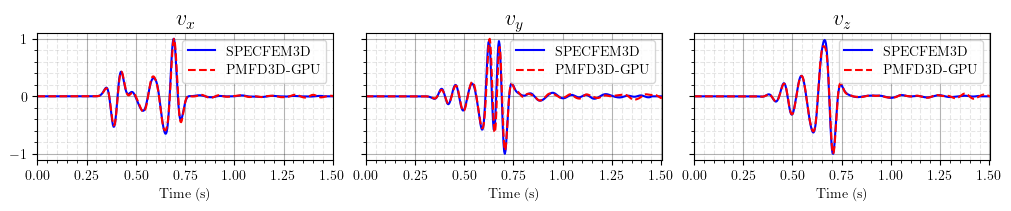

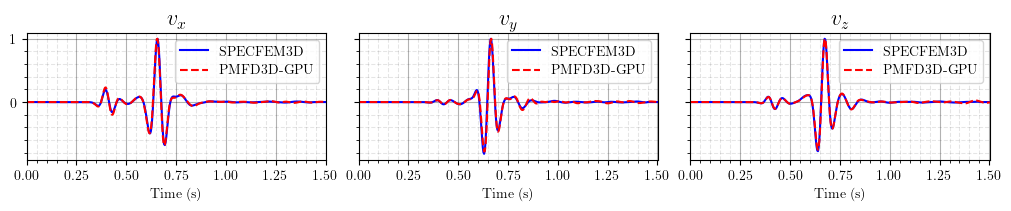

In [121]:
plt.rcParams['figure.figsize'] = [10, 2]

for recx in [50,100,200,250]:
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, layout='constrained', sharey=True)
    ax1.set_title('$v_x$', fontsize=16)
    ax1.plot(time,dataX_norm[:,recx],'b')
    ax1.plot(time,dataXavm_norm[:,recx],'r--')
    ax1.grid(True, which='major', color='k', linestyle='-', alpha=0.3)
    ax1.grid(True, which='minor', color='k', linestyle='--', alpha=0.1)
    ax1.minorticks_on()
    ax1.set_xlabel('Time (s)')
    ax1.legend(['SPECFEM3D','PMFD3D-GPU'])
    ax1.set_xlim((time[0],time[-1]))

    ax2.set_title('$v_y$', fontsize=16)
    ax2.plot(time,dataY_norm[:,recx],'b')
    ax2.plot(time,dataYavm_norm[:,recx],'r--')
    ax2.grid(True, which='major', color='k', linestyle='-', alpha=0.3)
    ax2.grid(True, which='minor', color='k', linestyle='--', alpha=0.1)
    ax2.minorticks_on()
    ax2.set_xlabel('Time (s)')
    ax2.legend(['SPECFEM3D','PMFD3D-GPU'])
    ax2.set_xlim((time[0],time[-1]))

    ax3.set_title('$v_z$', fontsize=16)
    ax3.plot(time,dataZ_norm[:,recx],'b')
    ax3.plot(time,dataZavm_norm[:,recx],'r--')
    ax3.grid(True, which='major', color='k', linestyle='-', alpha=0.3)
    ax3.grid(True, which='minor', color='k', linestyle='--', alpha=0.1)
    ax3.minorticks_on()
    ax3.set_xlabel('Time (s)')
    ax3.legend(['SPECFEM3D','PMFD3D-GPU'])
    ax3.set_xlim((time[0],time[-1]))
    #fig.savefig('traces_'+str(recx)+'.pdf',bbox_inches='tight')

In [101]:
error = []
for recx in [50,100,200,250]:
    error_x = 100*np.linalg.norm(dataX_norm[:,recx]-dataXavm_norm[:,recx])**2/np.linalg.norm(dataX_norm[:,recx])**2
    error_y = 100*np.linalg.norm(dataY_norm[:,recx]-dataYavm_norm[:,recx])**2/np.linalg.norm(dataY_norm[:,recx])**2
    error_z = 100*np.linalg.norm(dataZ_norm[:,recx]-dataZavm_norm[:,recx])**2/np.linalg.norm(dataZ_norm[:,recx])**2
    error.append([error_x,error_y,error_z])

print(tabulate(error, headers=["X", "Y", "Z"], floatfmt=".2f"))

   X     Y     Z
----  ----  ----
1.15  7.77  0.80
0.88  0.97  0.51
0.27  0.42  0.11
1.24  2.25  0.37


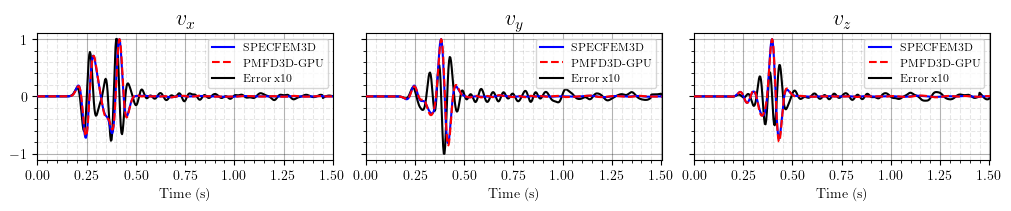

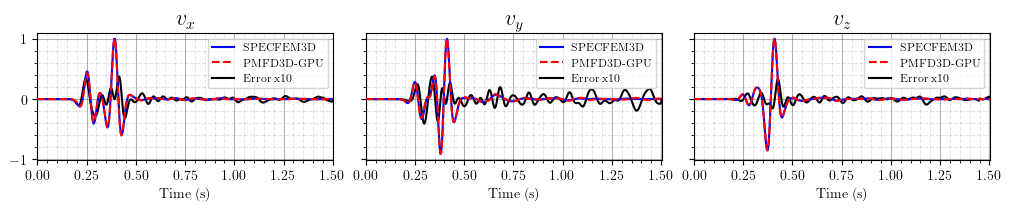

In [122]:
plt.rcParams['figure.figsize'] = [10, 2]
for recx in [50,100,200,250]:
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, layout='constrained', sharey=True)
    ax1.set_title('$v_x$', fontsize=16)
    ax1.plot(time,dataX_norm[:,recx],'b',zorder=5)
    ax1.plot(time,dataXavm_norm[:,recx],'r--',zorder=10)
    ax1.plot(time,10*(dataX_norm[:,recx]-dataXavm_norm[:,recx]),'k',zorder=0)
    ax1.grid(True, which='major', color='k', linestyle='-', alpha=0.3)
    ax1.grid(True, which='minor', color='k', linestyle='--', alpha=0.1)
    ax1.minorticks_on()
    ax1.set_xlabel('Time (s)')
    ax1.legend(['SPECFEM3D','PMFD3D-GPU','Error x10'], fontsize=8)
    ax1.set_xlim((time[0],time[-1]))

    ax2.set_title('$v_y$', fontsize=16)
    ax2.plot(time,dataY_norm[:,recx],'b',zorder=5)
    ax2.plot(time,dataYavm_norm[:,recx],'r--',zorder=10)
    ax2.plot(time,10*(dataY_norm[:,recx]-dataYavm_norm[:,recx]),'k',zorder=0)
    ax2.grid(True, which='major', color='k', linestyle='-', alpha=0.3)
    ax2.grid(True, which='minor', color='k', linestyle='--', alpha=0.1)
    ax2.minorticks_on()
    ax2.set_xlabel('Time (s)')
    ax2.legend(['SPECFEM3D','PMFD3D-GPU','Error x10'], fontsize=8)
    ax2.set_xlim((time[0],time[-1]))

    ax3.set_title('$v_z$', fontsize=16)
    ax3.plot(time,dataZ_norm[:,recx],'b',zorder=5)
    ax3.plot(time,dataZavm_norm[:,recx],'r--',zorder=10)
    ax3.plot(time,10*(dataZ_norm[:,recx]-dataZavm_norm[:,recx]),'k',zorder=0)
    ax3.grid(True, which='major', color='k', linestyle='-', alpha=0.3)
    ax3.grid(True, which='minor', color='k', linestyle='--', alpha=0.1)
    ax3.minorticks_on()
    ax3.set_xlabel('Time (s)')
    ax3.legend(['SPECFEM3D','PMFD3D-GPU','Error x10'], fontsize=8)
    ax3.set_xlim((time[0],time[-1]))
    fig.savefig('traces_error'+str(recx)+'.pdf',bbox_inches='tight')